### Interest Rate Modeling with Vasicek Model

In [1]:
import pandas as pd
import numpy as np
import scipy as si
from scipy import stats
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
np.random.seed(1)

In [2]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()  # allows using dates for indexing

In [3]:
# from interesrate.csv, read the following columns into df: Date, Short Term Interest Rates, Personal Income,	Consumer Prices(Inflation,)	Industrial Production,	Consumer Confidence,	Money Supply- Currency/Demand Deposit/Traveller Check,	Money Supply- Deposit

df_orig = pd.read_csv(
    "interestdata.csv",
    parse_dates=["Date"],
    index_col=["Date"],
    usecols=[
        "Date",
        "Short Term Interest Rates",
        "Personal Income",
        "Industrial Production",
        "Money Supply- Currency/Demand Deposit/Traveller Check",
        "Money Supply- Deposit",
    ],
)

In [4]:
df = df_orig.copy()
df.dropna(inplace=True)

In [5]:
df.describe()

,Short Term Interest Rates,Personal Income,Industrial Production,Money Supply- Currency/Demand Deposit/Traveller Check,Money Supply- Deposit
count,601.000000,601.000000,601.000000,601.000000,601.000000
mean,4.965740,8.120665,77.174078,2531.943759,6484.538940
std,3.916953,38.881432,21.191365,4592.027031,5431.025780
min,0.090000,-81.049850,39.952099,257.899994,839.299988
25%,1.340000,3.376319,55.053501,633.500000,2533.100098
50%,5.150000,5.888639,84.951599,1118.500000,4267.600098
75%,7.030000,8.804394,97.978798,1896.500000,8943.500000
max,18.650000,867.957458,104.118103,20664.199220,21703.599610


In [6]:
df.shape

(601, 5)

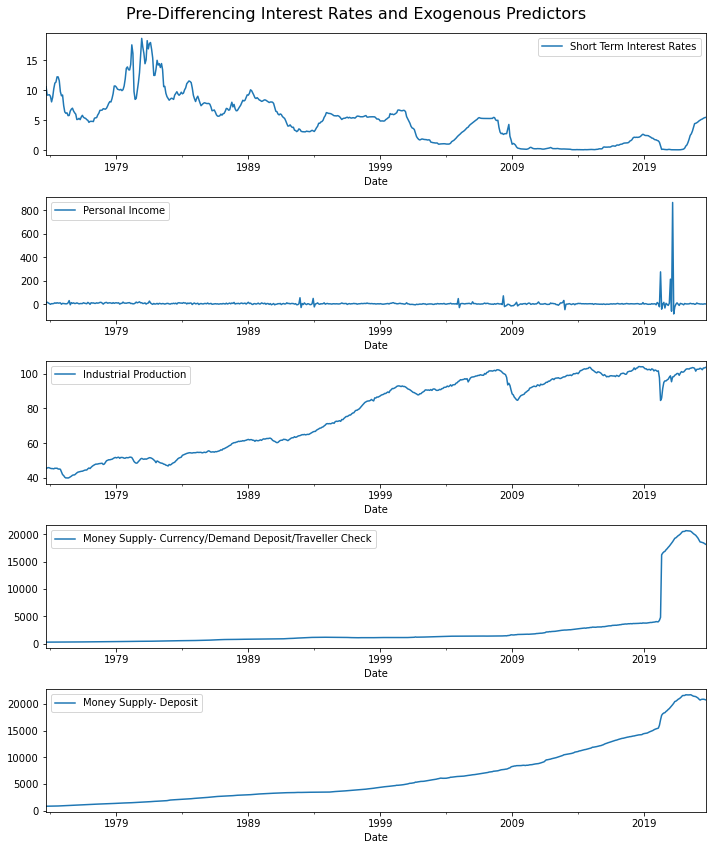

In [7]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(df.columns), figsize=(10, 12))

# Add a title to the figure
fig.suptitle("Pre-Differencing Interest Rates and Exogenous Predictors", fontsize=16)

# Plot each series in df on a separate subplot
for ax, column in zip(axes, df.columns):
    df[column].plot(ax=ax, legend=True)


# Automatically adjust subplot params so that the subplot fits into the figure area
plt.tight_layout()

# Adjust the top of the subplot area so that there is space for the title
plt.subplots_adjust(top=0.95)

# Display the plot
plt.show()

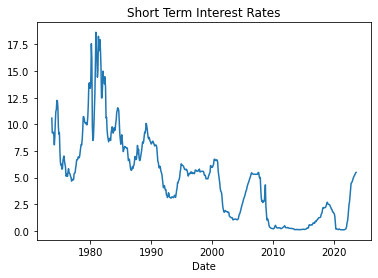

In [8]:
plt.plot(df.index, df["Short Term Interest Rates"])
plt.title("Short Term Interest Rates")
plt.xlabel("Date")
plt.show()

In [9]:
variables = [
    "Short Term Interest Rates",
    "Personal Income",
    "Industrial Production",
    "Money Supply- Currency/Demand Deposit/Traveller Check",
    "Money Supply- Deposit",
]

diff_df = pd.DataFrame()

for var in variables:
    diff_df[var] = df[var].diff()

# Drop the first row which is NaN due to differencing
diff_df = diff_df.dropna()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


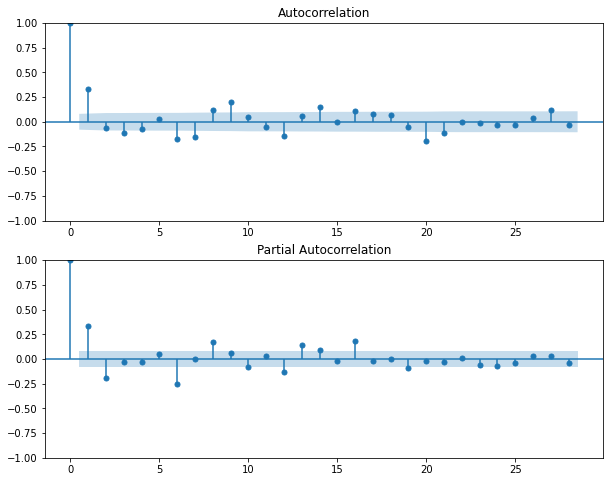

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the ACF and PACF of the differenced time series
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_df["Short Term Interest Rates"], ax=ax[0])
plot_pacf(diff_df["Short Term Interest Rates"], ax=ax[1])
plt.show()

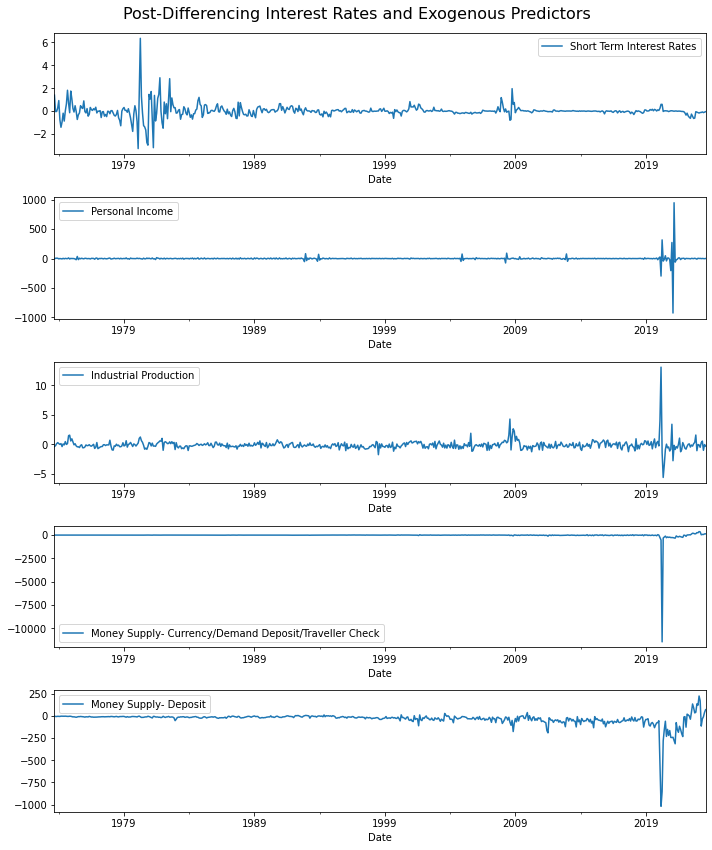

In [11]:
fig, axes = plt.subplots(nrows=len(diff_df.columns), figsize=(10, 12))

# Add a title to the figure
fig.suptitle("Post-Differencing Interest Rates and Exogenous Predictors", fontsize=16)

# Plot each series in df on a separate subplot
for ax, column in zip(axes, diff_df.columns):
    diff_df[column].plot(ax=ax, legend=True)


# Automatically adjust subplot params so that the subplot fits into the figure area
plt.tight_layout()

# Adjust the top of the subplot area so that there is space for the title
plt.subplots_adjust(top=0.95)

# Display the plot
plt.show()

In [12]:
# using scikit learn, split my data into training and testing sets (80/20) and make the test set the last 20% of the data

diff_df = diff_df.dropna()
diff_df = diff_df.sort_values(by=["Date"], ascending=True)
from sklearn.model_selection import train_test_split

ARtrain_data, ARtest_data = train_test_split(diff_df, test_size=0.2, shuffle=False)

In [78]:
ARtrain_data

,Short Term Interest Rates,Personal Income,Industrial Production,Money Supply- Currency/Demand Deposit/Traveller Check,Money Supply- Deposit
Date,,,,,
1973-09-01,1.39,-6.159237,-0.362999,-1.100006,-3.299988
1973-10-01,-0.04,5.389927,-0.206402,-2.000000,-6.300048
1973-11-01,-0.03,6.497945,0.128502,-1.899994,-6.599976
1973-12-01,0.27,5.703328,0.302399,-0.899994,-4.200012
1974-01-01,0.92,-5.732913,0.131500,-1.500000,-4.500000
...,...,...,...,...,...
2013-04-01,0.00,-3.144143,-0.090905,-18.600098,-34.700190
2013-05-01,0.01,4.168906,-0.185699,2.500000,-57.700200
2013-06-01,0.05,3.716382,0.316604,-21.300049,-39.700190


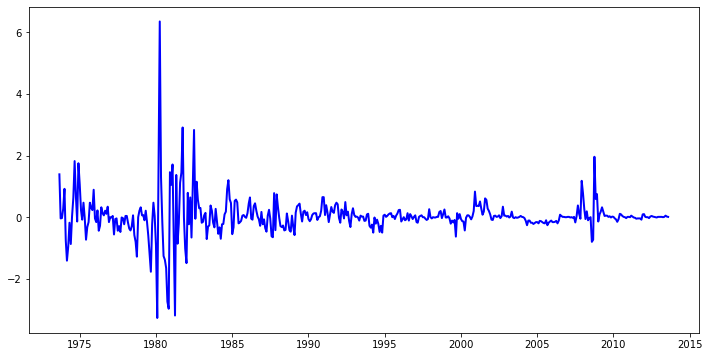

In [14]:

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the training data
ax.plot(
    ARtrain_data["Short Term Interest Rates"],
    label="Training Data",
    color="blue",
    linewidth=2,
)

In [15]:
interest_rates   = ARtrain_data.iloc[ :600, :1]
interest_rates

,Short Term Interest Rates
Date,
1973-09-01,1.39
1973-10-01,-0.04
1973-11-01,-0.03
1973-12-01,0.27
1974-01-01,0.92
...,...
2013-04-01,0.00
2013-05-01,0.01
2013-06-01,0.05


In [16]:
interest_rates_b = interest_rates.shift(+1)
interest_rates_b

,Short Term Interest Rates
Date,
1973-09-01,NaN
1973-10-01,1.39
1973-11-01,-0.04
1973-12-01,-0.03
1974-01-01,0.27
...,...
2013-04-01,0.01
2013-05-01,0.00
2013-06-01,0.01


In [17]:
interest_rates   = interest_rates.iloc[1:,]
interest_rates

,Short Term Interest Rates
Date,
1973-10-01,-0.04
1973-11-01,-0.03
1973-12-01,0.27
1974-01-01,0.92
1974-02-01,-0.76
...,...
2013-04-01,0.00
2013-05-01,0.01
2013-06-01,0.05


In [18]:
interest_rates_b = interest_rates_b.dropna(axis = 0)
interest_rates_b

,Short Term Interest Rates
Date,
1973-10-01,1.39
1973-11-01,-0.04
1973-12-01,-0.03
1974-01-01,0.27
1974-02-01,0.92
...,...
2013-04-01,0.01
2013-05-01,0.00
2013-06-01,0.01


In [19]:
interest_rates   = ARtrain_data.iloc[ :600, :1]
interest_rates_b = interest_rates.shift(+1)
interest_rates   = interest_rates.iloc[1:,]
interest_rates_b = interest_rates_b.dropna(axis = 0)

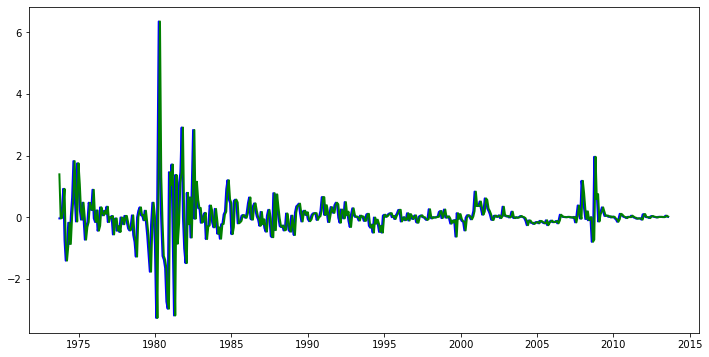

In [20]:

# Create a new figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the training data
ax.plot(
    interest_rates,
    label="Training Data",
    color="blue",
    linewidth=2,
)

# Plot the training data
ax.plot(
    interest_rates_b,
    label="Training Data",
    color="green",
    linewidth=2,
)

In [21]:
# interest_rates['r(t)-r(t-1)']    = interest_rates['Short Term Interest Rates'] - interest_rates['Short Term Interest Rates'].shift(+1)
# interest_rates['Mean_Reversion'] = a*(b-interest_rates['Short Term Interest Rates'].shift(+1))
# interest_rates['Model_Mean']     = interest_rates['Short Term Interest Rates'] - interest_rates['Short Term Interest Rates'].shift(+1) - a*(b-interest_rates['Short Term Interest Rates'].shift(+1))  
# interest_rates = interest_rates.dropna(axis = 0)
# interest_rates

In [22]:
# interest_rates['pdf'] = stats.norm.logpdf(interest_rates['Model_Mean'], loc=0, scale=sd)  
# interest_rates.head()

In [23]:
# interest_rates_b

In [51]:
def Vasicek(params):
    a  = params[0]   
    b  = params[1]
    sd = params[2]
    
    interest_rates   = ARtrain_data.iloc[ :600, :1]
    interest_rates_b = interest_rates.shift(+1)
    interest_rates   = interest_rates.iloc[1:,]
    interest_rates_b = interest_rates_b.dropna(axis = 0)
    sample_data = interest_rates['Short Term Interest Rates'] - interest_rates_b['Short Term Interest Rates'] - a*(b-interest_rates_b['Short Term Interest Rates'])
    
    # Calculate negative log likelihood
    nll = -np.sum(stats.norm.logpdf(sample_data, loc=0, scale=sd))

    return nll


initParams = [1, 2, 1]

results = minimize(Vasicek, initParams, method='Nelder-Mead')
print(results.x)

[0.6797947  0.01765537 0.5799317 ]


### Prediction

In [65]:
from numpy import random as rn

We use the MLE as the parameter as our predicitve model.

In [66]:
a = results.x[0]
b = results.x[1]
σ = results.x[2]

The last interest rate in the training data is 0.2.

In [67]:
r0 = 0.2

The forcast horizon is 10 years from the end of the traiing data. (2013 -> 2023)

In [68]:
T = 10

Let’s set the number of short intervals (months).

In [69]:
N = 120

In [70]:
δt = T/N
δt

0.08333333333333333

We choose to use 50,000 simulations.

In [71]:
M = int(5*1e4)
M

50000

In [72]:
dz = rn.randn(M,N)

In [73]:
r = r0*np.ones((M,N+1))

In [74]:
for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*dz[:,i]*np.sqrt(δt)

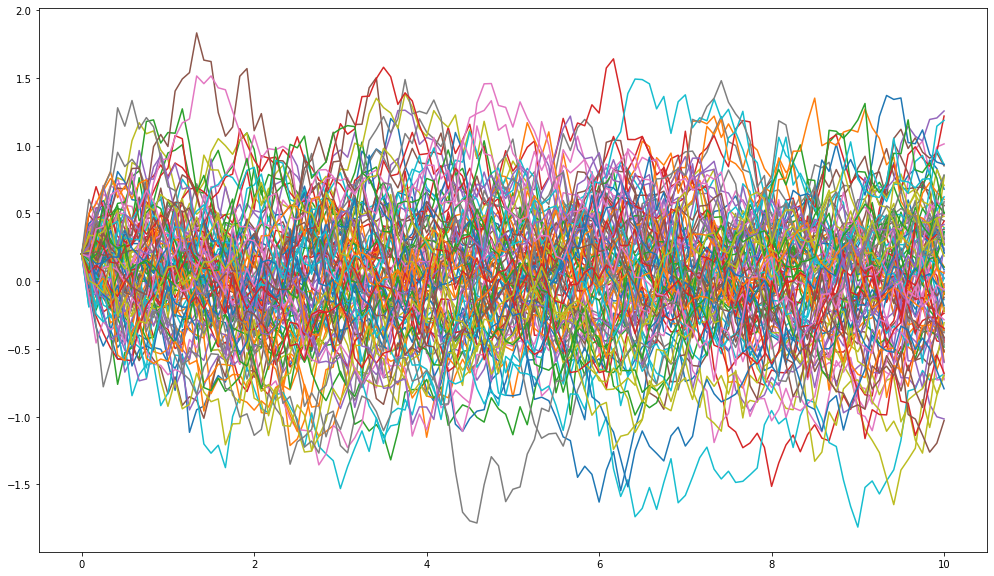

In [75]:
plt.figure(figsize=(17,10))

a = [ rn.randint(0,M) for j in range(1,100)]

for runer in a:
    plt.plot(np.arange(0,T+δt,δt)[:-1],r[runer])

In [76]:
pred_mean = np.mean(r, axis=0)
pred_SE   = np.ones(121)

def normsinv(x):
    x = si.stats.norm.ppf(x)
    return (x)

z = normsinv(0.975)
for i in range(1,121):
    pred_SE[i] = z*np.std(r[:i])/np.sqrt(i)


z = normsinv(0.975)

print("Lower 95% is:",format( (μ-z*SE) ))
print("Mean% is:",format( (μ) ))
print("Upper 95% is:",format( (μ+z*SE) ))

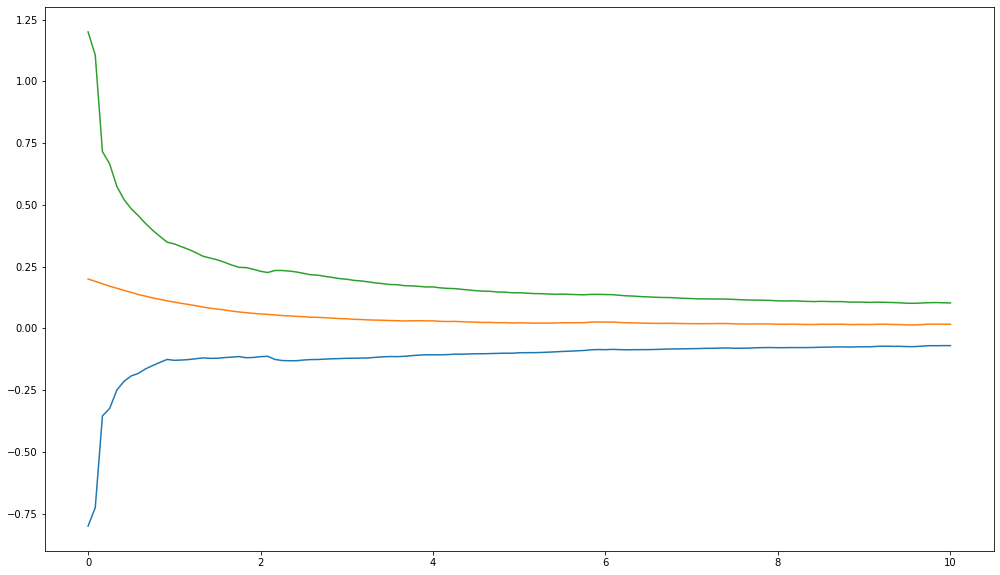

In [77]:
plt.figure(figsize=(17,10))


plt.plot(np.arange(0,T+δt,δt)[:-1],pred_mean - pred_SE)
plt.plot(np.arange(0,T+δt,δt)[:-1],pred_mean)
plt.plot(np.arange(0,T+δt,δt)[:-1],pred_mean + pred_SE)


In [167]:
r.shape

(50000, 121)

In [165]:
V = (r[:,-1])
print("The expected value for the interest rate is:", format(np.mean(V)))
print("The standard error of sample mean is:", format(np.std(V)/np.sqrt(M)))

The expected value for the interest rate is: 0.012591118099333744
The standard error of sample mean is: 0.0022632873876029342


In [166]:
from scipy.stats import norm
def normsinv(x):
    x = norm.ppf(x)
    return (x)

z = normsinv(0.975)
μ = np.mean(V)
SE = np.std(V)/np.sqrt(M)

print("Lower 95% is:",format( (μ-z*SE) ))
print("Mean% is:",format( (μ) ))
print("Upper 95% is:",format( (μ+z*SE) ))

Lower 95% is: 0.008155156332968247
Mean% is: 0.012591118099333744
Upper 95% is: 0.017027079865699242


In [169]:
M

50000